In [23]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
os.chdir("/home/naxos2-raid25/kneel027/home/kneel027/MindEye_Imagery/src/depth_anything/")
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import DPTFeatureExtractor, DPTForDepthEstimation, CLIPVisionModelWithProjection
from diffusers import AutoPipelineForText2Image, DiffusionPipeline, LCMScheduler, StableDiffusionXLImg2ImgPipeline, StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from diffusers.utils import load_image
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
)
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
    use_safetensors=True,
    variant="fp16"
)
# pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="sdxl_models",
    weight_name=[
        "ip-adapter-plus_sdxl_vit-h.safetensors"
    ] ,
    image_encoder_folder="models/image_encoder"
)
pipeline.set_ip_adapter_scale(1.0)
pipeline.scheduler = LCMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_lora_weights("latent-consistency/lcm-lora-sdxl")
pipeline.fuse_lora()
pipeline.enable_model_cpu_offload()

# image_encoder = CLIPVisionModelWithProjection.from_pretrained(
#     "h94/IP-Adapter",
#     subfolder="models/image_encoder",
#     torch_dtype=torch.float16,
# )
# depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
# feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")
# controlnet = ControlNetModel.from_pretrained(
#     "diffusers/controlnet-depth-sdxl-1.0",
#     variant="fp16",
#     use_safetensors=True,
#     torch_dtype=torch.float16,
# )
# vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
# pipeline = AutoPipelineForText2Image.from_pretrained(
#     "stabilityai/stable-diffusion-xl-base-1.0",
#     # controlnet=controlnet,
#     vae=vae,
#     variant="fp16",
#     use_safetensors=True,
#     image_encoder=image_encoder,
#     torch_dtype=torch.float16,
# )
# # pipeline.unet = torch.compile(pipeline.unet, mode="reduce-overhead", fullgraph=True)
# pipeline.load_ip_adapter("h94/IP-Adapter", 
#             subfolder="sdxl_models", 
#             weight_name="ip-adapter_sdxl_vit-h.safetensors",
#             image_encoder_folder="models/image_encoder")
# pipeline.set_ip_adapter_scale(1.0)
# pipeline.scheduler = LCMScheduler.from_config(pipeline.scheduler.config)
# pipeline.load_lora_weights("latent-consistency/lcm-lora-sdxl")
# pipeline.fuse_lora()
# pipeline.enable_model_cpu_offload()

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)

    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [24]:
style_folder = "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy"
style_images = load_image(f"{style_folder}/img0.png")

image_embeds = pipeline.prepare_ip_adapter_image_embeds(
    ip_adapter_image=style_images,
    ip_adapter_image_embeds=None,
    device="cuda",
    num_images_per_prompt=1,
    do_classifier_free_guidance=True
)
torch.save(image_embeds, "image_embeds.ipadpt")

print(f"type: {type(image_embeds)}")
print(f"len: {len(image_embeds)}")
for embeds in image_embeds:
    print(f"shape: {embeds.shape}")

type: <class 'list'>
len: 1
shape: torch.Size([2, 1, 257, 1280])


  0%|          | 0/4 [00:00<?, ?it/s]

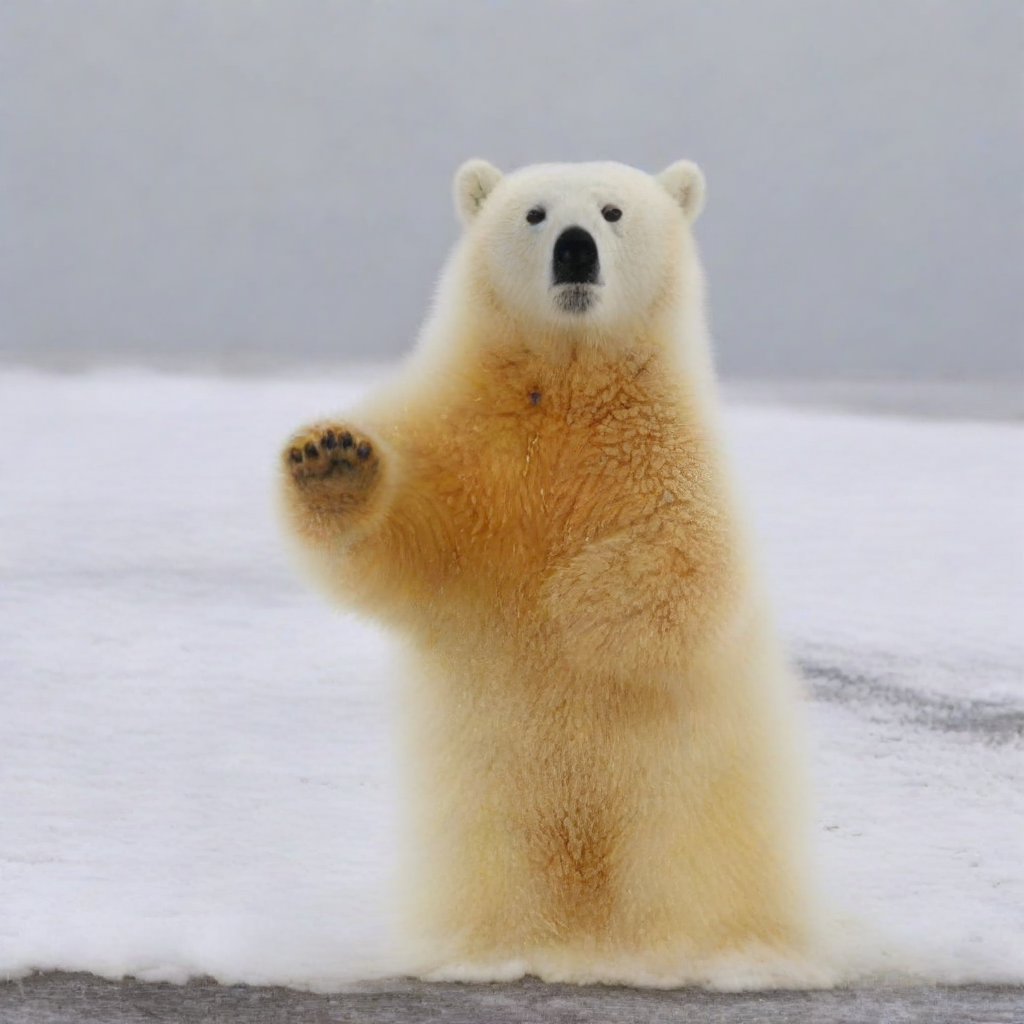

In [26]:
bear = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_bear_1.png")
mountain = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_bear_2.png")
bear_depth = get_depth_map(bear)
mountain_depth = get_depth_map(mountain)
import matplotlib.pyplot as plt

# plt.imshow(bear_depth)
# plt.axis('off')
# plt.show()

# plt.imshow(mountain_depth)
# plt.axis('off')
# plt.show()
generator = torch.Generator(device="cpu").manual_seed(4)
images = pipeline(
    prompt="",
    image=mountain_depth,
    controlnet_conditioning_scale = 0.3,
    ip_adapter_image=bear,
    # generator=generator,
    num_inference_steps=4,
    guidance_scale=0,
    # controls denoising process
    # strength=1,
    # controls the strength of ip guidance
    scale=1.0
).images
images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:32,  3.62s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:07<00:29,  3.67s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:11<00:25,  3.69s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:14<00:22,  3.69s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:18<00:18,  3.70s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:22<00:14,  3.70s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:25<00:11,  3.70s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:29<00:07,  3.70s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:33<00:03,  3.70s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:36<00:00,  3.70s/it]


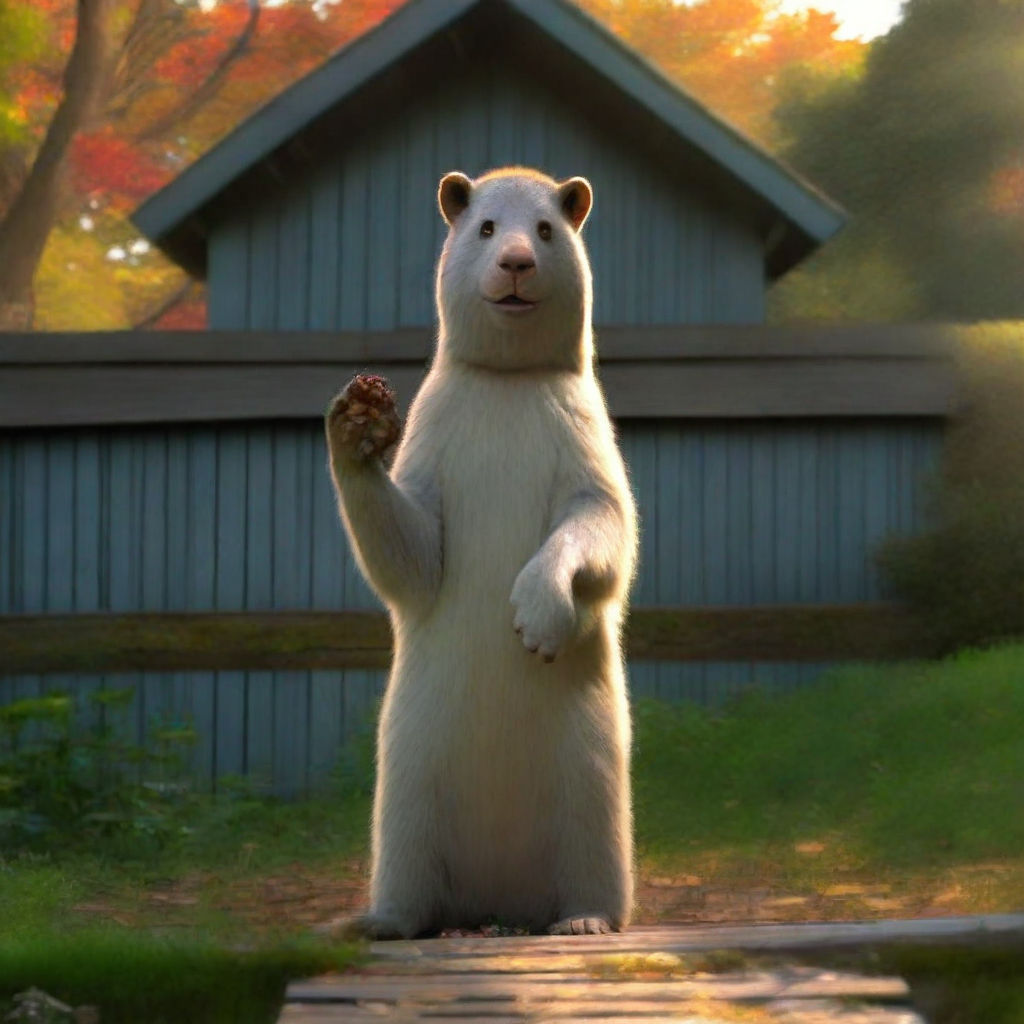

In [27]:
from tqdm import tqdm
for i in tqdm(range(10)):
    images = pipeline(
        prompt="",
        image=bear_depth,
        ip_adapter_image_embeds=image_embeds,
        # negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
        num_inference_steps=4,
        # generator=generator,
        guidance_scale=0,
        controlnet_conditioning_scale = 0.4,
        # strength=1.0,
        scale=1.0
    ).images
images[0]

In [ ]:
import torch
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from diffusers.utils import load_image
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
)
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
    use_safetensors=True,
    variant="fp16"
)
# pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="sdxl_models",
    weight_name=[
        "ip-adapter-plus_sdxl_vit-h.safetensors"
    ] ,
    image_encoder_folder="models/image_encoder"
)
pipeline.set_ip_adapter_scale(1.0)
pipeline.scheduler = LCMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_lora_weights("latent-consistency/lcm-lora-sdxl")
pipeline.fuse_lora()
pipeline.enable_model_cpu_offload()

style_folder = "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy"
style_images = load_image(f"{style_folder}/img0.png")

image_embeds = pipeline.prepare_ip_adapter_image_embeds(
    ip_adapter_image=style_images,
    ip_adapter_image_embeds=None,
    device="cuda",
    num_images_per_prompt=1,
    do_classifier_free_guidance=True
)
torch.save(image_embeds, "image_embeds.ipadpt")

print(f"type: {type(image_embeds)}")
print(f"len: {len(image_embeds)}")
for embeds in image_embeds:
    print(f"shape: {embeds.shape}")

/export/raid1/home/kneel027/mamba/envs/mindeye_imagery_ip/lib/python3.11/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


type: <class 'list'>
len: 1
shape: torch.Size([2, 1, 257, 1280])
